# Retail Giant Forecasting

## Problem Statement

**Global Mart is an online supergiant store that has worldwide operations. This store takes orders and delivers across the globe and deals with all the major product categories — consumer, corporate and home office.**

 

**As a sales manager for this store, you have to forecast the sales of the products for the next 6 months, so that you have a proper estimate and can plan your inventory and business processes accordingly.**

# Segment-1 :- Data Understanding

## Importing the libraries and reading the dataset

In [30]:
#Importing the Useful Libraries and Functions

# Suppress Warnings

import warnings
warnings.filterwarnings("ignore")

# Import Numpy and Pandas Library

import pandas as pd
import numpy as np

# Import Matplotlib and Seaborn Libraries for Data visualization

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Using Pandas Inbuilt function to display all columns and rows present in Dataset

pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)

# Using Pylab Library and importing rcParams function for Time Series Decompostion

from pylab import rcParams

# Importing Statsmodel Library
import statsmodels.api as sm

# Importing Exponential Smoothing Functions from Statsmodels Library
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Importing Augumented Dickey Fuller Function from Statsmodel Library
from statsmodels.tsa.stattools import adfuller

#Importing Kwiatkowski-Phillips-Schmidt-Shin Function from Statsmodel Library
from statsmodels.tsa.stattools import kpss

#Importing Box Cox Function from Scipy Library
from scipy.stats import boxcox

#Importing ARIMA Auto-Regressive Models from Statsmodel Library
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [31]:
# Reading the dataset

Retail_Giant = pd.read_csv("Global+Superstore+Data.csv")

In [32]:
# Printing the first five rows of the dataframe 'leads'

Retail_Giant.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


## Data Inspection

### Basic Structure Checking

In [33]:
# Checking the shape of dataframe

Retail_Giant.shape 

(51290, 5)

**There are 51290 rows and 5 columns initially.**

### Checking missing values

In [34]:
# Calculating the missing values in each column of the dataframe

Retail_Giant.isnull().sum().sort_values(ascending=False)

Order Date    0
Segment       0
Market        0
Sales         0
Profit        0
dtype: int64

***Observation:***

- There are no missing values in this dataframe.

In [35]:
# Printing information about the attributes of 'leads'

Retail_Giant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


## Data Preparation

### Changing Data Type of Order Date Column

In [36]:
Retail_Giant['Order Date'] = pd.to_datetime(Retail_Giant['Order Date'], format='%d-%m-%Y').dt.to_period('m')
Retail_Giant= Retail_Giant.sort_values(by=['Order Date'])

In [37]:
#Checking the info again

Retail_Giant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51290 entries, 30643 to 44106
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   Order Date  51290 non-null  period[M]
 1   Segment     51290 non-null  object   
 2   Market      51290 non-null  object   
 3   Sales       51290 non-null  float64  
 4   Profit      51290 non-null  float64  
dtypes: float64(2), object(2), period[M](1)
memory usage: 2.3+ MB


### Concatenating Market and Segment Column



In [38]:
Retail_Giant['Market-Segment']=Retail_Giant['Market'] + '-' + Retail_Giant['Segment']
Retail_Giant.head()

,Order Date,Segment,Market,Sales,Profit,Market-Segment
30643,2011-01,Consumer,LATAM,60.9600,28.6400,LATAM-Consumer
48527,2011-01,Consumer,US,19.3000,5.7900,US-Consumer
29861,2011-01,Home Office,APAC,51.6285,4.5885,APAC-Home Office
29871,2011-01,Consumer,LATAM,47.9600,15.8000,LATAM-Consumer
16508,2011-01,Consumer,APAC,176.6808,-156.6792,APAC-Consumer


### Dropping Market And Segment Columns

In [39]:
Retail_Giant.drop(['Market','Segment'],axis=1,inplace=True)
Retail_Giant.head()

,Order Date,Sales,Profit,Market-Segment
30643,2011-01,60.9600,28.6400,LATAM-Consumer
48527,2011-01,19.3000,5.7900,US-Consumer
29861,2011-01,51.6285,4.5885,APAC-Home Office
29871,2011-01,47.9600,15.8000,LATAM-Consumer
16508,2011-01,176.6808,-156.6792,APAC-Consumer


# Segment-2:- Exploratory Data Analysis

## Plotting Sales for each Segment

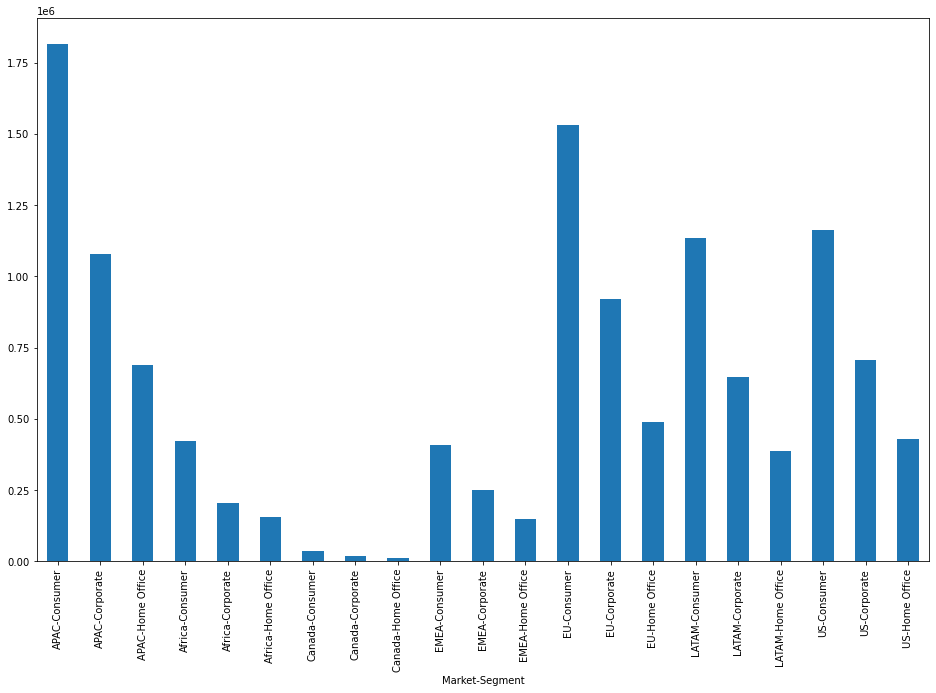

In [40]:
plt.figure(figsize=(16,10))
Retail_Giant.groupby(by='Market-Segment')['Sales'].sum().plot(kind='bar')
plt.show()

***Insight***

- APAC-Consumer has the highest Sales among 21 Market Segments

## Plotting Profit for each Segment 

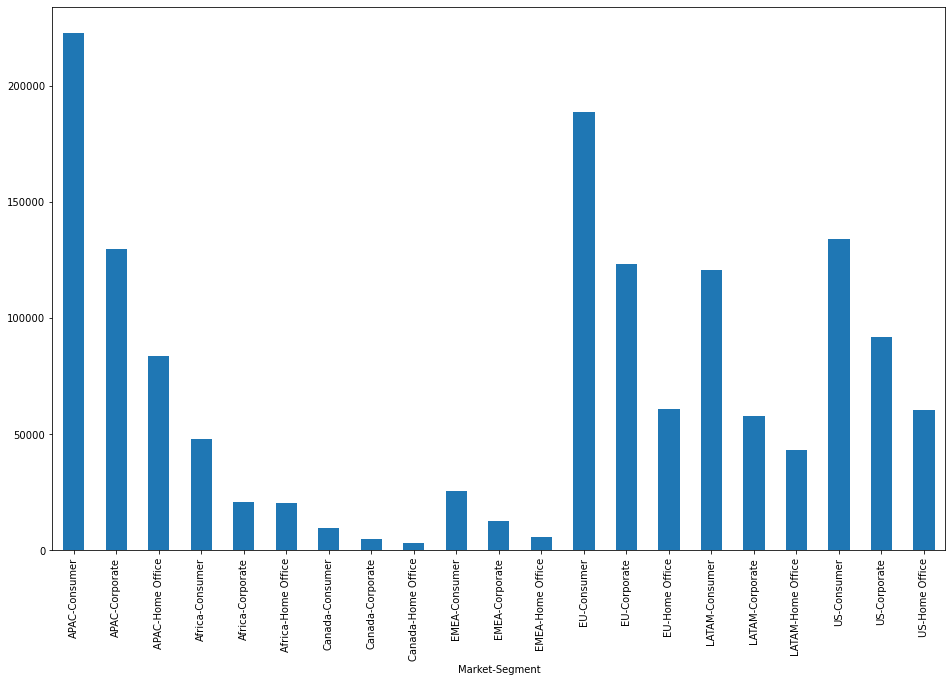

In [41]:
plt.figure(figsize=(16,10))
Retail_Giant.groupby(by='Market-Segment')['Profit'].sum().plot(kind='bar')
plt.show()

***Insight***

- APAC-Consumer has the highest Sales among 21 Market Segments

# Segment-3:-Data Preprocessing for  Model Building

## Creating Pivot-Table for aggregated profit values on monthly basis

In [42]:
Retail_Giant_pivot=Retail_Giant.pivot_table(index='Order Date', values='Profit', 
                                            columns='Market-Segment', aggfunc='sum')
Retail_Giant_pivot.head()

Market-Segment,APAC-Consumer,APAC-Corporate,APAC-Home Office,Africa-Consumer,Africa-Corporate,Africa-Home Office,Canada-Consumer,Canada-Corporate,Canada-Home Office,EMEA-Consumer,EMEA-Corporate,EMEA-Home Office,EU-Consumer,EU-Corporate,EU-Home Office,LATAM-Consumer,LATAM-Corporate,LATAM-Home Office,US-Consumer,US-Corporate,US-Home Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,991.2825,11.5998,86.4423,475.683,219.096,856.710,3.12,5.7,NaN,-2099.364,1555.512,116.400,-845.8290,501.9315,975.360,1976.98976,1150.88400,-106.48800,762.8067,300.9145,1383.0499
2011-02,1338.8688,4358.8254,-417.4128,1441.926,-490.551,820.302,23.31,NaN,87.99,267.060,982.092,216.690,-1808.1180,2988.4065,-181.041,902.37752,721.25420,300.19936,500.2865,307.2995,58.1420
2011-03,3747.1632,1213.3386,923.7492,322.140,-586.716,67.320,335.55,NaN,84.03,1598.718,390.102,78.972,2480.5410,736.9890,503.223,2585.17924,39.07512,285.46400,597.2773,333.0515,-431.5989
2011-04,3846.4746,71.0265,657.1080,292.122,776.691,500.136,55.08,NaN,NaN,-300.879,93.900,-420.090,2496.6405,1056.1785,63.858,387.72148,259.25600,-421.73440,1155.0757,1393.3828,940.3767
2011-05,3639.9423,2534.1672,-272.1717,110.004,241.338,34.926,77.97,NaN,NaN,568.302,-24.270,262.968,254.0805,1586.2740,201.102,1002.34724,-531.74444,-240.11600,698.9171,2063.5013,-23.7088


In [43]:
#Displaying the columns in Pivot Table

Retail_Giant_pivot.columns

Index(['APAC-Consumer', 'APAC-Corporate', 'APAC-Home Office',
       'Africa-Consumer', 'Africa-Corporate', 'Africa-Home Office',
       'Canada-Consumer', 'Canada-Corporate', 'Canada-Home Office',
       'EMEA-Consumer', 'EMEA-Corporate', 'EMEA-Home Office', 'EU-Consumer',
       'EU-Corporate', 'EU-Home Office', 'LATAM-Consumer', 'LATAM-Corporate',
       'LATAM-Home Office', 'US-Consumer', 'US-Corporate', 'US-Home Office'],
      dtype='object', name='Market-Segment')

## Performing Train-Test Split

In [44]:
train_len=42
train=Retail_Giant_pivot[0:train_len] # First 42 Months as Training Set 
test=Retail_Giant_pivot[train_len:] # Last 6 Months as Test Set 

## Coefficient of Variance (COV) on Profit

- To find the most consistently profitable market-segment you will be using a measure called "Coefficient of Variation (CoV)"
- The coefficient of variation or CoV is nothing but the ratio of the standard deviation to mean for the data

In [45]:
Retail_Giant_cov = pd.DataFrame(columns = ['Market-Segment', 'COV'])

for i in Retail_Giant_pivot.columns:
    var = {"Market-Segment": i, "COV": np.std(train[i])/np.mean(train[i])}
    Retail_Giant_cov = Retail_Giant_cov.append(var, ignore_index=True)

#Sorting the dataframe in ascending order of COV values

Retail_Giant_cov.sort_values(by='COV',inplace=True)
Retail_Giant_cov

,Market-Segment,COV
0,APAC-Consumer,0.596404
12,EU-Consumer,0.647485
15,LATAM-Consumer,0.680684
13,EU-Corporate,0.689346
1,APAC-Corporate,0.731926
16,LATAM-Corporate,0.880260
19,US-Corporate,1.027209
2,APAC-Home Office,1.048817
18,US-Consumer,1.095295
14,EU-Home Office,1.114681


***Observation***

**Since we want very less variation in profit we will choose the Market Segment with least value of COV i.e. APAC-Customer for our further forecasting purposes.**

## Convert the Order-Date column from "DateTime" to "timestamp" so that we can use the data for further analysis

In [46]:
Retail_Giant['Order Date'] = Retail_Giant['Order Date'].astype(str)
Retail_Giant['Order Date']=pd.to_datetime(Retail_Giant['Order Date'])

In [47]:
#Checking the info again

Retail_Giant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51290 entries, 30643 to 44106
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Order Date      51290 non-null  datetime64[ns]
 1   Sales           51290 non-null  float64       
 2   Profit          51290 non-null  float64       
 3   Market-Segment  51290 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 2.0+ MB



## Extracting the Final Dataset for forecasting

In [48]:
Retail_Giant_forecasting = Retail_Giant[Retail_Giant['Market-Segment']=='APAC-Consumer']
Retail_Giant_forecasting.head()

,Order Date,Sales,Profit,Market-Segment
16508,2011-01-01,176.6808,-156.6792,APAC-Consumer
24801,2011-01-01,69.3000,3.4200,APAC-Consumer
16608,2011-01-01,219.9600,8.7600,APAC-Consumer
9787,2011-01-01,337.6395,-122.8005,APAC-Consumer
29891,2011-01-01,30.4560,12.0960,APAC-Consumer


## Grouping data based on Order date and finding sales

In [49]:
Retail_Final=pd.DataFrame(Retail_Giant_forecasting.groupby("Order Date")['Sales'].sum())
Retail_Final.head()

,Sales
Order Date,
2011-01-01,15711.7125
2011-02-01,12910.8588
2011-03-01,19472.5632
2011-04-01,15440.3046
2011-05-01,24348.9723


# Segment-3:-Time Series Decomposition

## Additive Seasonal Decomposition

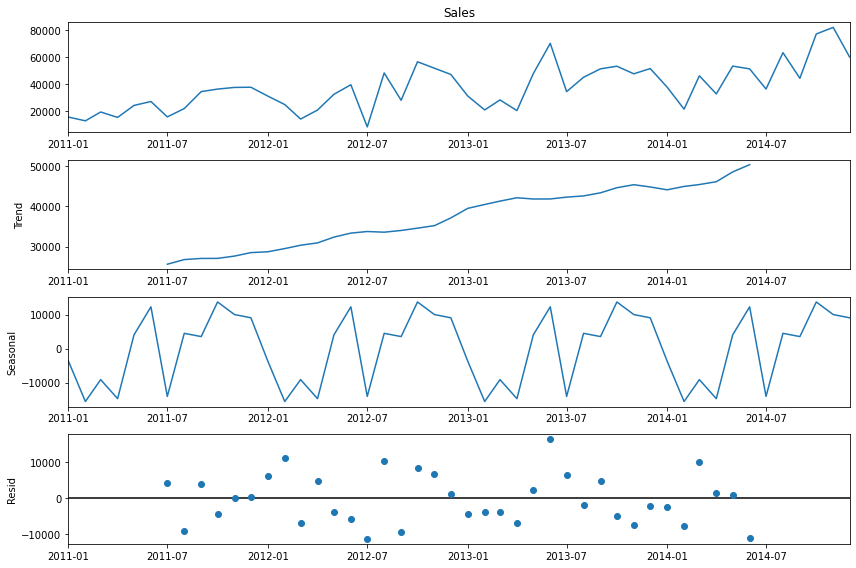

In [50]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(Retail_Final.Sales, model='additive')
fig = decomposition.plot()
plt.show()

## Multiplicative seasonal decomposition

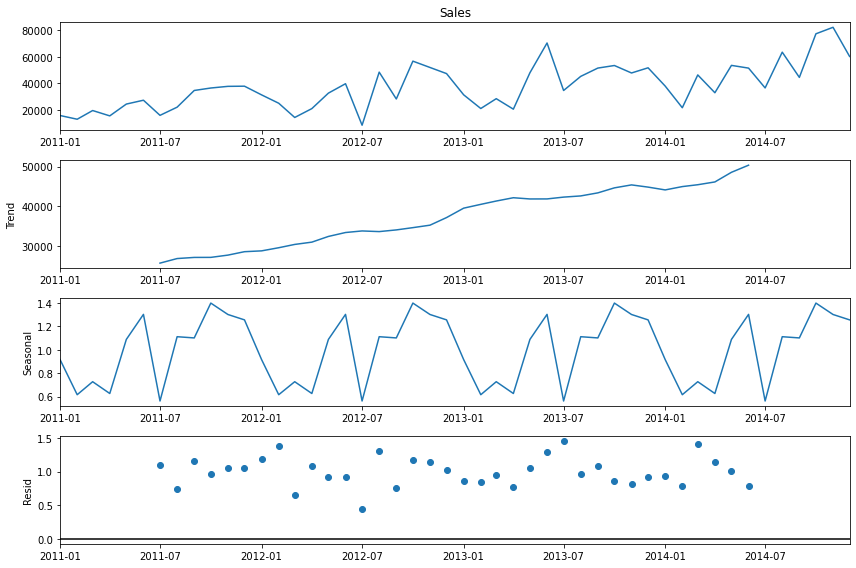

In [51]:
decomposition = sm.tsa.seasonal_decompose(Retail_Final.Sales, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

***Insights***

- Using this Time Series Decomposition we were able to decompose Trend,Seasonality and Residual Noise from our data.

- There is clear upward Trend in the data given

- Data shows clear seasonal pattern as well

- Since the data has more than 10 observations and shows trend and seasonality as well hence we can conclude that Holt Winters exponential smoothing method or SARIMA Auto Regressive method will perform best based on flowchart. However we shall proceed with the models one by one and see how it performs.

# Segment-4 :- Building and evaluating Exponential time series forecasting Models

## Split time series data into training and test set

In [52]:
train_len=42
train=Retail_Final[0:train_len]
test=Retail_Final[train_len:]

## Exponential smoothing methods

### Simple exponential smoothing

- This technique helps us forecast the level in the time series data.

In [53]:
model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))

#### Plot train, test and forecast

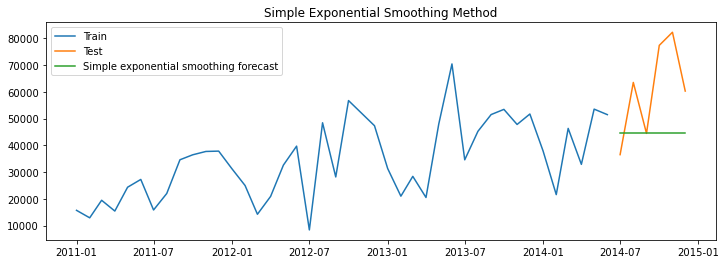

In [54]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

#### Calculating  MAPE for Evaluating the Model

In [55]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ses['ses_forecast'])/test['Sales'])*100,2)
results = pd.DataFrame({'Method':['Simple exponential smoothing forecast'],'MAPE': [mape]})
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,27.7


### Holt's method with trend

- This technique forecasts the level and trend of the time series data.

In [56]:
# seasonal period set as 12 months for this method and assuming trend to be additive
model = ExponentialSmoothing(np.asarray(train['Sales']),seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.45285714285714285, 'smoothing_trend': 0.0646938775510204, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 15711.7125, 'initial_trend': -2800.8536999999997, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Plot train, test and forecast

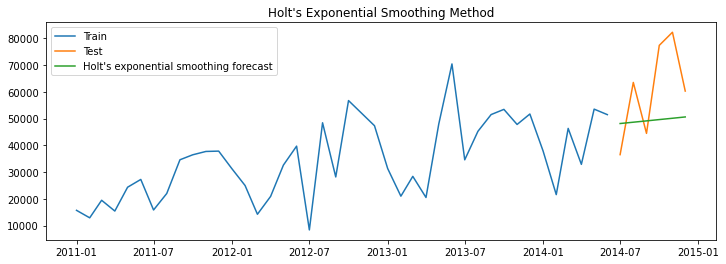

In [57]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

#### Calculating  MAPE for Evaluating the Model

In [58]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_holt['holt_forecast'])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method','MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,27.70
0,Holt's exponential smoothing method,26.12


### Holt Winters' additive method with trend and seasonality

- This technique forecasts the level, trend and seasonality of the time series data.

In [59]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.040357142857142855, 'smoothing_trend': 0.040357142857142855, 'smoothing_seasonal': 0.13709183673469388, 'damping_trend': nan, 'initial_level': 29061.2919, 'initial_trend': 730.4167145833331, 'initial_seasons': array([-13349.5794, -16150.4331,  -9588.7287, -13620.9873,  -4712.3196,
        -1801.2723, -13218.4602,  -7049.0553,   5551.893 ,   7410.7551,
         8661.312 ,   8785.6992]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Plot train, test and forecast

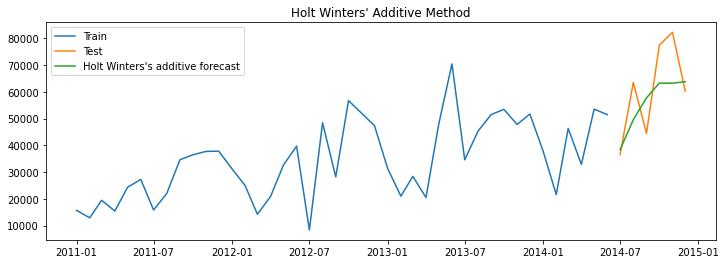

In [60]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

#### Calculating  MAPE for Evaluating the Model

In [61]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwa['hw_forecast'])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,27.70
0,Holt's exponential smoothing method,26.12
0,Holt Winters' additive method,17.32


### Holt Winter's multiplicative method with trend and seasonality

- Multiplies the trended forecast by the seasonality

In [62]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.005, 'smoothing_trend': 0.005, 'smoothing_seasonal': 0.3198214285714286, 'damping_trend': nan, 'initial_level': 29061.2919, 'initial_trend': 730.4167145833331, 'initial_seasons': array([0.54064054, 0.44426307, 0.67005153, 0.53130138, 0.83784893,
       0.93801816, 0.54515235, 0.75744178, 1.19104082, 1.25500432,
       1.29803603, 1.3023162 ]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Plot train, test and forecast

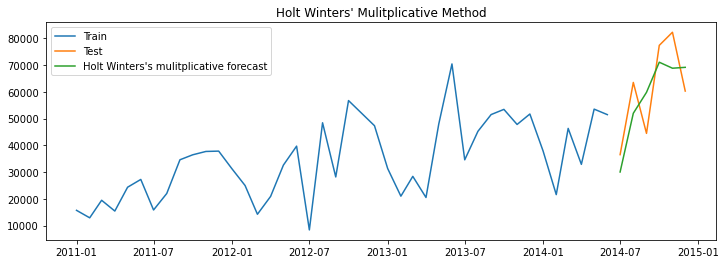

In [63]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

#### Calculating  MAPE for Evaluating the Model

In [64]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwm['hw_forecast'])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method','MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,27.70
0,Holt's exponential smoothing method,26.12
0,Holt Winters' additive method,17.32
0,Holt Winters' multiplicative method,18.27


# Segment-5 :- Building and evaluating Auto Regressive Time Series Forecasting Models

## Checking and Converting the Time Series into Stationary Time Series

### Stationarity vs non-stationary time series

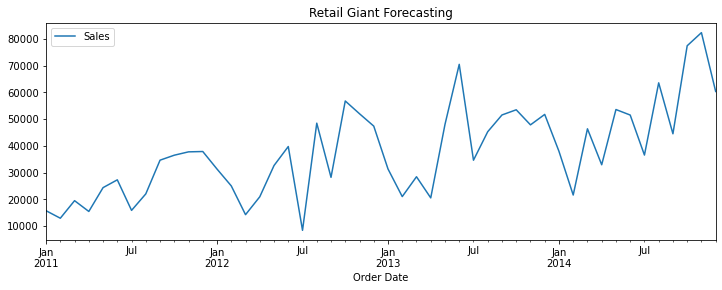

In [65]:
Retail_Final['Sales'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Retail Giant Forecasting')
plt.show(block=False)

***Insight***

- From the above plot we can see clearly that data has changing level and showing upward trend. To validate and check the stationarity of dataset we will do ADF and KPSS test respectively.

### Augmented Dickey-Fuller (ADF) test

In [66]:
adf_test = adfuller(Retail_Final['Sales'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.220857
Critical Values @ 0.05: -2.93
p-value: 0.198763


***Conclusion***

- **Null Hypothesis  (H0) : The series is not stationary  p−value>0.05**
- **Alternate Hypothesis: (H1)  The series is stationary  p−value<=0.05**

- Since the p- value observed is more than 0.05 we failed to reject the null hypothesis and conclude that the dataset provided is not stationary.

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [67]:
kpss_test = kpss(Retail_Final['Sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.595515
Critical Values @ 0.05: 0.46
p-value: 0.023044


***Conclusion***

- **Null Hypothesis  (H0) : The series is stationary  p−value>0.05**
- **Alternate Hypothesis: (H1)  The series is not stationary  p−value<=0.05**

- Since the p- value observed is less than 0.05 we can say reject the null hypothesis and conclude that the dataset provided is not stationary.

### Box Cox transformation to make variance constant

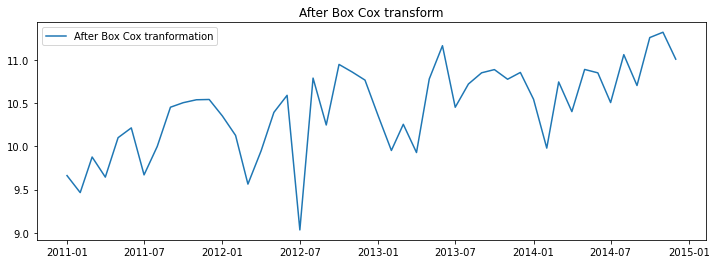

In [68]:
Retail_boxcox = pd.Series(boxcox(Retail_Final['Sales'], lmbda=0), index = Retail_Final.index)
plt.figure(figsize=(12,4))
plt.plot(Retail_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing to remove trend

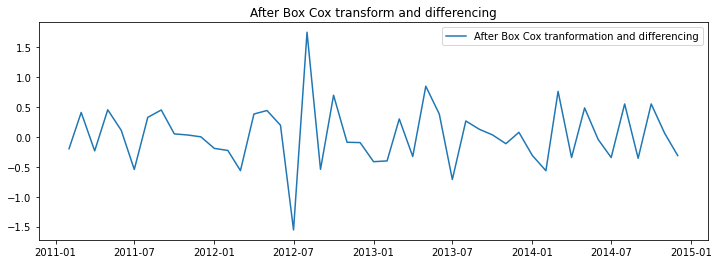

In [69]:
Retail_boxcox_diff = pd.Series(Retail_boxcox - Retail_boxcox.shift(), Retail_Final.index)
plt.figure(figsize=(12,4))
plt.plot(Retail_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [70]:
Retail_boxcox_diff.dropna(inplace=True)

### Augmented Dickey-Fuller (ADF) test

In [71]:
adf_test = adfuller(Retail_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -5.769275
Critical Values @ 0.05: -2.95
p-value: 0.000001


***Conclusion***

- **Null Hypothesis  (H0) : The series is not stationary  p−value>0.05**
- **Alternate Hypothesis: (H1)  The series is stationary  p−value<=0.05**

- Since the p- value observed is less than 0.05 we reject the null hypothesis and conclude that the dataset after box cox transformation and differencing is stationary.

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [72]:
kpss_test = kpss(Retail_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.135659
Critical Values @ 0.05: 0.46
p-value: 0.100000


***Conclusion***

- **Null Hypothesis  (H0) : The series is stationary  p−value>0.05**
- **Alternate Hypothesis: (H1)  The series is not stationary  p−value<=0.05**

- Since the p- value observed is greater than 0.05 we fail to reject the null hypothesis and conclude that the dataset after box cox transformation and differencing is stationary.

### Performimg Train-Test Split for building ARIMA Models

In [73]:
train_data_boxcox = Retail_boxcox[:train_len]
test_data_boxcox = Retail_boxcox[train_len:]
train_data_boxcox_diff = Retail_boxcox_diff[:train_len-1]
test_data_boxcox_diff = Retail_boxcox_diff[train_len-1:]

## Auto regression method (AR)

- This model predicts the future observation as linear regression of one or more past observations.
- This model has a parameter ‘p’ called lag order which is calculated by finding the highest value in PACF plot.
- Here p=1 as mentioned in Problem Statement

In [74]:
model = ARIMA(train_data_boxcox_diff, order=(1,0,0))
model_fit = model.fit()
print(model_fit.params)

const      0.031320
ar.L1.y   -0.483978
dtype: float64


### Recover original time series

In [75]:
y_hat_ar = Retail_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(Retail_boxcox_diff.index.min(), Retail_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(Retail_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plot train, test and forecast

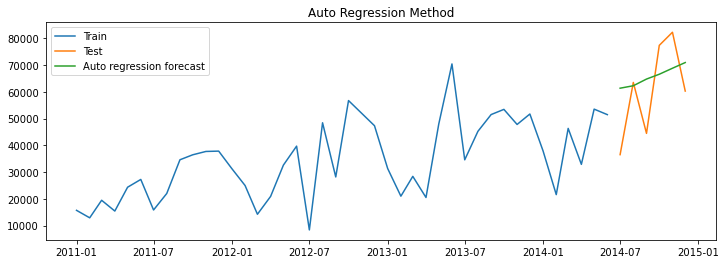

In [76]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculating  MAPE for Evaluating the Model

In [77]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method','MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,27.70
0,Holt's exponential smoothing method,26.12
0,Holt Winters' additive method,17.32
0,Holt Winters' multiplicative method,18.27
0,Autoregressive (AR) method,27.27


## Moving average method (MA)

- This model predicts the future forecasts using past forecast errors in a regression-like model.
- This model has a parameter ‘q’ called window size over which linear combination of errors are calculated which is highest value in ACF plot.
- Here q=1 as mentioned in Problem Statement

In [78]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.022694
ma.L1.y   -1.000000
dtype: float64


### Recover original time series

In [79]:
y_hat_ma = Retail_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(Retail_boxcox_diff.index.min(), Retail_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(Retail_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train, test and forecast

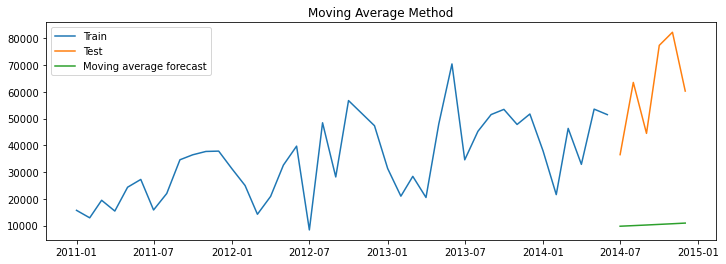

In [80]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Calculating  MAPE for Evaluating the Model

In [81]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,27.70
0,Holt's exponential smoothing method,26.12
0,Holt Winters' additive method,17.32
0,Holt Winters' multiplicative method,18.27
0,Autoregressive (AR) method,27.27
0,Moving Average (MA) method,81.64


## Auto regression moving average method (ARMA)

- A time series that exhibits the characteristics of an AR(p) and/or an MA(q) process can be modelled using an ARMA(p,q) model.
- Here p=1 and q=1 as mentioned in Problem Statement

In [82]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.022810
ar.L1.y    0.115928
ma.L1.y   -0.999954
dtype: float64


### Recover original time series

In [83]:
y_hat_arma = Retail_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(Retail_boxcox_diff.index.min(), Retail_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(Retail_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast

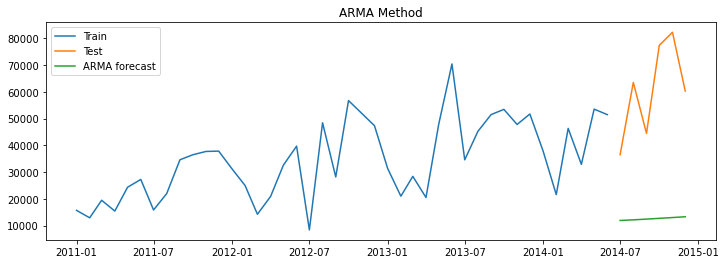

In [84]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

### Calculating  MAPE for Evaluating the Model

In [85]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,27.70
0,Holt's exponential smoothing method,26.12
0,Holt Winters' additive method,17.32
0,Holt Winters' multiplicative method,18.27
0,Autoregressive (AR) method,27.27
0,Moving Average (MA) method,81.64
0,Autoregressive moving average (ARMA) method,77.66


## Auto regressive integrated moving average (ARIMA)

- ARIMA model has three parameters
    - p: Highest lag included in the regression model
    - d: Degree of differencing to make the series stationary
    - q: Number of past error terms included in the regression model
- Here p=1, d=1, q=1 as mentioned in Problem Statement

In [86]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.022810
ar.L1.D.y    0.115928
ma.L1.D.y   -0.999954
dtype: float64


### Recover original time series forecast

In [87]:
y_hat_arima = Retail_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(Retail_boxcox_diff.index.min(), Retail_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(Retail_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast

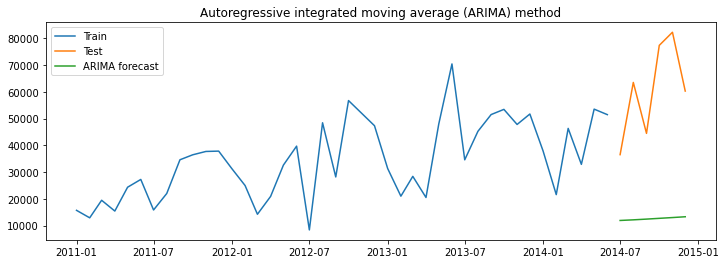

In [88]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Calculating  MAPE for Evaluating the Model

In [89]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['ARIMA method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,27.70
0,Holt's exponential smoothing method,26.12
0,Holt Winters' additive method,17.32
0,Holt Winters' multiplicative method,18.27
0,Autoregressive (AR) method,27.27
0,Moving Average (MA) method,81.64
0,Autoregressive moving average (ARMA) method,77.66
0,ARIMA method,77.66


## Seasonal auto regressive integrated moving average (SARIMA)

- SARIMA Model has both non seasonal elements and seasonal elements.
- SARIMA brings all the features of an ARIMA model with an extra feature - seasonality. 
- SARIMA has six parameters along with seasonality.

- Non-seasonal elements
    - p: Trend autoregression order
    - d: Trend difference order
    - q: Trend moving average order
- Seasonal elements
    - m: The number of time steps for a single seasonal period
    - P: Seasonal autoregressive order
    - D: Seasonal difference order
    - Q: Seasonal moving average order

In [90]:
model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.100504
ma.L1      -0.994122
ar.S.L12   -0.394385
ma.S.L12   -0.986498
sigma2      0.047415
dtype: float64


### Recover original time series forecast

In [91]:
y_hat_sarima = Retail_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(Retail_boxcox_diff.index.min(), Retail_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

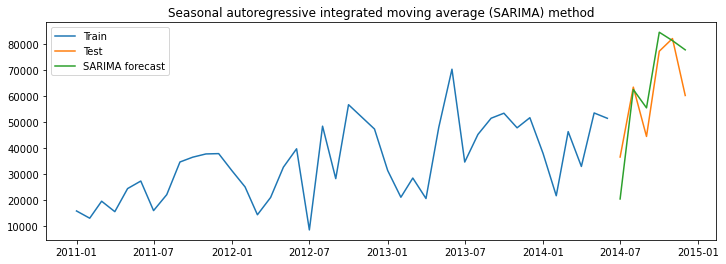

In [92]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculating  MAPE for Evaluating the Model

In [93]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['SARIMA method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,27.70
0,Holt's exponential smoothing method,26.12
0,Holt Winters' additive method,17.32
0,Holt Winters' multiplicative method,18.27
0,Autoregressive (AR) method,27.27
0,Moving Average (MA) method,81.64
0,Autoregressive moving average (ARMA) method,77.66
0,ARIMA method,77.66
0,SARIMA method,18.38


In [94]:
# Sorting Final Results based on ascending order of MAPE values

results_final = results.sort_values(by='MAPE')
results_final

,Method,MAPE
0,Holt Winters' additive method,17.32
0,Holt Winters' multiplicative method,18.27
0,SARIMA method,18.38
0,Holt's exponential smoothing method,26.12
0,Autoregressive (AR) method,27.27
0,Simple exponential smoothing forecast,27.70
0,Autoregressive moving average (ARMA) method,77.66
0,ARIMA method,77.66
0,Moving Average (MA) method,81.64


# Conclusion

- APAC-Consumer Segment proved to be most Profitable Segment based on COV Value.

- From the Simple Exponential Smoothing Methods Holt Winter's Additive Method performed best since it has lowest MAPE value among exponential Smoothing Methods

- From the Auto Regressive Models SARIMA method performed best since it has lowest MAPE value among auto regressive models

- Overall Holt Winter's Method performed best since it has lowest MAPE value among all.

- While Doing Time Series Decomposition we have observed that data has Trend and Seasonality hence Holt Winters or SARIMA model will perform better on this data since they capture Trend and Seasonality better than any other Models.